# CS4035 - Cyber Data Analytics
## Lab 3 

# --- NOTES ---

- Discretize each "netflow" (which is just a single packet/row)
- For each feature, create "bins" for the values (nunique? LabelEncoder?) 
- Concatenate all of these bins into a single feature, such that the dataset only has one feature (confirm?)
- Use k-means to create clusters, and then "utilize the interaction between the features to come up with the features" (optional)


- [Student] "so each row has 1 feature after the concatenation. Since we need a 3-gram, doesn't this essentialy mean that we take row 1, row 2 and row 3 as the first 3-gram? Is then the second 3-gram, row 2, row 3, row 4?"
- [Daniel Vos] "Yes, essentially. You summarize each row with one number/symbol and take 3-grams of these numbers/symbols"

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name: Andrew Gold
### ID: 4995902

## Student 2
### Name :
### ID :

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

In [288]:
df_10 = pd.read_pickle("./dataset_10/capture20110818.pkl")
# df_10 = pd.read_pickle("./dataset_10/capture_no_background.pkl")

# Drop the following columns because...
df_10.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_10.drop(index=np.where(df_10['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_10.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_10.reset_index(drop=True, inplace=True)
df_10.head()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label
0,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,3049,978731,245317,flow=From-Normal-V51-Grill
1,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
2,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
3,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek
4,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek


In [289]:
# First let's see what kind of null values we've got
df_10.isnull().sum()

Dur              0
Proto            0
SrcAddr          0
Sport           27
Dir              0
DstAddr          0
Dport       101196
State         1227
TotPkts          0
TotBytes         0
SrcBytes         0
Label            0
dtype: int64

In [290]:
# Fill the NaN values
df_10.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER

In [291]:
# Relabel some of the directional flows to be less ambiguous
df_10.Dir.loc[np.where(df_10.Dir == "->")] = 'send'
df_10.Dir.loc[np.where(df_10.Dir == "<-")] = 'receive'
df_10.Dir.loc[np.where(df_10.Dir == "<->")] = 'both'
df_10.Dir.loc[np.where(df_10.Dir == "<?>")] = 'other'
df_10.Dir.loc[np.where(df_10.Dir == "?>")] = 'other'
df_10.Dir.loc[np.where(df_10.Dir == "who")] = 'other'

C:\ProgramData\Anaconda3\envs\labs\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [292]:
for col in df_10.columns:
    print(col, df_10[col].nunique())

Dur 16922
Proto 4
SrcAddr 28
Sport 62662
Dir 4
DstAddr 351
Dport 947
State 121
TotPkts 481
TotBytes 2532
SrcBytes 2032
Label 75


<BarContainer object of 4 artists>

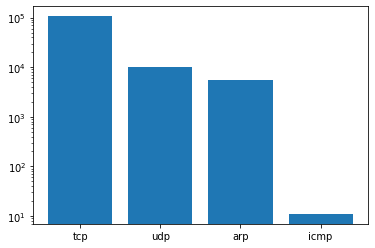

In [293]:
plt.yscale('log')
plt.bar(df_10.Proto.unique(), df_10.Proto.value_counts())

<BarContainer object of 4 artists>

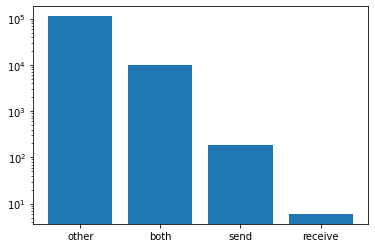

In [294]:
plt.yscale('log')
plt.bar(df_10.Dir.unique(), df_10.Dir.value_counts())

<BarContainer object of 28 artists>

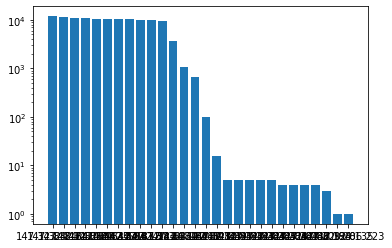

In [295]:
plt.yscale('log')
plt.bar(df_10.SrcAddr.unique(), df_10.SrcAddr.value_counts())

In [296]:
# Let's see what kind of different labels we have
print(df_10.Label.value_counts().to_string())

flow=From-Botnet-V51-6-ICMP                                  11836
flow=From-Botnet-V51-7-ICMP                                  11252
flow=From-Botnet-V51-5-ICMP                                  11125
flow=From-Botnet-V51-9-ICMP                                  11081
flow=From-Botnet-V51-8-ICMP                                  10541
flow=From-Botnet-V51-2-ICMP                                  10415
flow=From-Botnet-V51-3-ICMP                                  10363
flow=From-Normal-V51-Stribrek                                10216
flow=From-Botnet-V51-4-ICMP                                   9970
flow=From-Botnet-V51-10-ICMP                                  9857
flow=From-Botnet-V51-1-ICMP                                   9537
flow=From-Normal-V51-Grill                                    3728
flow=From-Normal-V51-Jist                                     1091
flow=From-Normal-V51-UDP-CVUT-DNS-Server                       667
flow=From-Normal-V51-CVUT-WebServer                           

In [304]:
disc_labels = pd.Series(df_10.Label)
botnet_labels = pd.Series(df_10.Label.loc[np.where(df_10.Label.str.contains('Botnet'))])

disc_labels.loc[np.where(disc_labels.str.contains('From-Normal'))] = 'From-Normal'
disc_labels.loc[np.where(disc_labels.str.contains('To-Normal'))] = 'To-Normal'
disc_labels.loc[np.where(disc_labels.str.contains('Normal-V'))] = 'Normal'
disc_labels.loc[np.where(botnet_labels.str.contains('ICMP'))] = 'Botnet-ICMP'
disc_labels.loc[np.where(botnet_labels.str.contains('UDP'))] = 'Botnet-UDP'
disc_labels.loc[np.where(botnet_labels.str.contains('TCP'))] = 'Botnet-TCP'


disc_labels


0          Botnet-UDP
1          Botnet-UDP
2          Botnet-TCP
3          Botnet-UDP
4          Botnet-UDP
             ...     
122194    From-Normal
122195    From-Normal
122196    From-Normal
122197    From-Normal
122198    From-Normal
Name: Label, Length: 122199, dtype: object

In [298]:
# Let's create a meta-label binary attribute for "attack" vs "normal"
df_10['Metalabel'] = pd.Series()
df_10.Metalabel.loc[np.where(df_10.Label.str.contains('Botnet'))] = 1
df_10.Metalabel.loc[np.where(df_10.Label.str.contains('Normal'))] = 0
df_10.Metalabel = df_10.Metalabel.astype('int8')
df_10


<ipython-input-298-0211a71a0c02>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10['Metalabel'] = pd.Series()


,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,Metalabel
0,3587.569824,tcp,147.32.84.164,54784,other,74.125.232.215,443,PA_PA,3049,978731,245317,Botnet-UDP,1
1,198.072739,tcp,147.32.84.164,56165,other,74.125.232.197,80,FA_FA,14,924,462,Botnet-UDP,1
2,197.928329,tcp,147.32.84.164,57965,other,209.85.149.138,80,FA_FA,14,924,462,Botnet-TCP,1
3,0.000399,udp,147.32.84.170,45807,both,147.32.80.9,53,CON,2,400,74,Botnet-UDP,1
4,0.000400,udp,147.32.84.170,35380,both,147.32.80.9,53,CON,2,400,74,Botnet-UDP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122194,0.000743,icmp,147.32.84.164,0x0008,both,147.32.96.69,0x841e,ECO,2,196,98,From-Normal,0
122195,0.000913,icmp,147.32.84.164,0x0008,both,147.32.96.69,0x841e,ECO,2,196,98,From-Normal,0
122196,0.000414,udp,147.32.84.170,37138,both,147.32.80.9,53,CON,2,244,81,From-Normal,0
122197,0.000322,udp,147.32.84.170,39771,both,147.32.80.9,53,CON,2,280,81,From-Normal,0


## 1. Familiarization and discretization task – 1 A4

In [299]:
df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122199 entries, 0 to 122198
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Dur        122199 non-null  float64
 1   Proto      122199 non-null  object 
 2   SrcAddr    122199 non-null  object 
 3   Sport      122199 non-null  object 
 4   Dir        122199 non-null  object 
 5   DstAddr    122199 non-null  object 
 6   Dport      122199 non-null  object 
 7   State      122199 non-null  object 
 8   TotPkts    122199 non-null  int64  
 9   TotBytes   122199 non-null  int64  
 10  SrcBytes   122199 non-null  int64  
 11  Label      122199 non-null  object 
 12  Metalabel  122199 non-null  int8   
dtypes: float64(1), int64(3), int8(1), object(8)
memory usage: 11.3+ MB


In [300]:
df_10.Dur = LabelEncoder().fit_transform(df_10.Dur)
df_10.Proto = LabelEncoder().fit_transform(df_10.Proto)
df_10.SrcAddr = LabelEncoder().fit_transform(df_10.SrcAddr)
df_10.Sport = LabelEncoder().fit_transform(df_10.Sport.astype('str'))
df_10.Dir = LabelEncoder().fit_transform(df_10.Dir)
df_10.DstAddr = LabelEncoder().fit_transform(df_10.DstAddr.astype('str'))
df_10.Dport = LabelEncoder().fit_transform(df_10.Dport.astype('str'))
df_10.State = LabelEncoder().fit_transform(df_10.State.astype('str'))
df_10.TotPkts = LabelEncoder().fit_transform(df_10.TotPkts)
df_10.TotBytes = LabelEncoder().fit_transform(df_10.TotBytes)
df_10.SrcBytes = LabelEncoder().fit_transform(df_10.SrcBytes)

# Might not want to blindly encode these
raw_labels = pd.Series(LabelEncoder().fit_transform(df_10.Label))

In [301]:
print(df_10.Label.value_counts().to_string())

Botnet-ICMP                                                  105977
flow=From-Botnet-V51-7-ICMP                                    2072
flow=From-Botnet-V51-9-ICMP                                    2044
flow=From-Botnet-V51-6-ICMP                                    1953
flow=From-Botnet-V51-10-ICMP                                   1873
flow=From-Botnet-V51-3-ICMP                                    1584
flow=From-Botnet-V51-8-ICMP                                    1363
flow=From-Botnet-V51-5-ICMP                                    1182
From-Normal                                                    1028
flow=From-Botnet-V51-1-ICMP                                     918
flow=From-Botnet-V51-2-ICMP                                     918
flow=From-Botnet-V51-4-ICMP                                     830
Botnet-UDP                                                      293
Botnet-TCP                                                       82
flow=From-Botnet-V51-8-UDP-DNS                  

In [302]:
print(df_10.Metalabel.value_counts().to_string())

1    121171
0      1028


<AxesSubplot:>

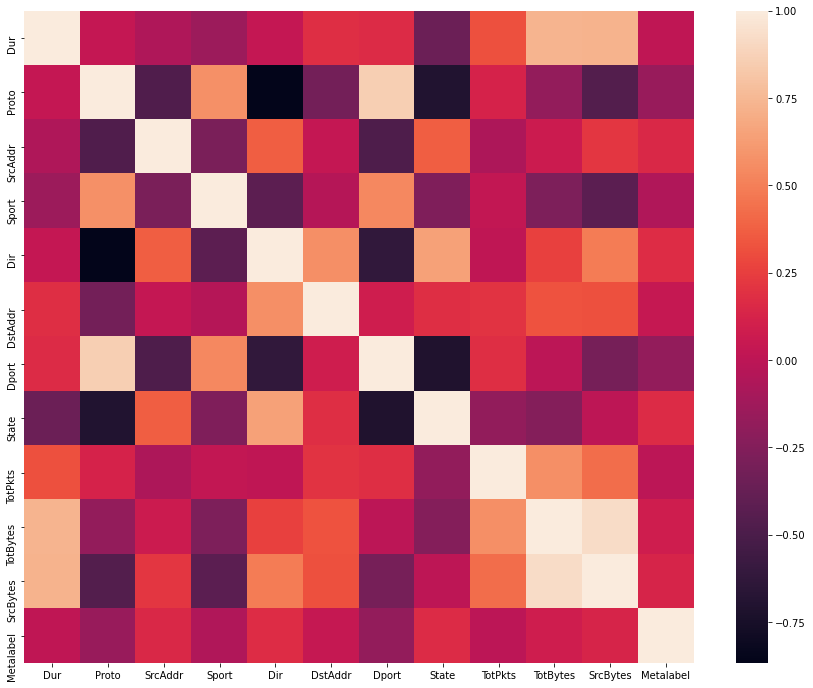

In [303]:
fig = plt.figure(figsize=(15,12))
sns.heatmap(df_10.corr())

In [266]:
# We can see that Source Address and Direction are the two most positively-correlated features with the Metalabel
# However, 


In [ ]:
df_10.

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

### 1b. Discretize selected features

### 1b. Answers and explanation

## 2. Frequent task – 1/2 A4 (Individual)

### 2a. Use the SPACE SAVING algorithm

### 2b. Analysis and answers to the questions

## 3. Sketching task – 1/2 A4 (Individual)

### 3a. COUNT-MIN sketch


### 3b. Analysis and answers to the questions

## 4. Min-wise locality sensitive hashing task – 1/2 A4 (Individual)

### 4a. Implementation

### 4b. Analysis and answers to the questions

## 5. Random hyperplane locality sensitive hashing task – 1/2 A4 (Individual)

### 5a. Implementation - locality sensitive hashing

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Botnet profiling task – 1/2 A4

### 6a. Learn a sequential model

### 6b. Analysis and answers to the questions.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


### 7b. Analysis and answers to the questions.

## 8. Bonus Task 1/2 A4

### 8a. Provide implementation and analysis.